In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from pydub import AudioSegment
import re

!pip install contractions
from contractions import fix
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.4 MB/s eta 0:00:00


In [2]:
# The dataset used is the common voice dataset from Mozilla. It is readily available on Kaggle

train_X_path = "/kaggle/input/common-voice/cv-valid-train"
train_y_path = "/kaggle/input/common-voice/cv-valid-train.csv"

test_X_path = "/kaggle/input/common-voice/cv-valid-test"
test_y_path = "/kaggle/input/common-voice/cv-valid-test.csv"

In [3]:
X_train = []
y_train = []
X_test = []
y_test = []

df = pd.read_csv(train_y_path)
x=0
for index, row in df.iterrows():
    X_train.append(os.path.join(train_X_path, row['filename']))
    y_train.append(row['text'])


df = pd.read_csv(test_y_path)
x=0
for index, row in df.iterrows():
    X_test.append(os.path.join(test_X_path, row['filename']))
    y_test.append(row['text'])

# **Preparing the Dataset**

**Processing the audios**

In [4]:
def pad_or_trim(audio, target_length):
    if len(audio) > target_length:
        # Trim if the audio is longer than target length
        return audio[:target_length]
    elif len(audio) < target_length:
        # Pad with zeros if the audio is shorter than target length
        padding = target_length - len(audio)
        return np.pad(audio, (0, padding), mode='constant')
    return audio


def log_mel_spectrogram(audio, sr=16000, n_mels=80, n_fft=400, hop_length=160):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec


def process_audio(path):
    audio, sr = librosa.load(path, sr=None)
    audio = pad_or_trim(audio, 500000)
    mel_spectrogram = log_mel_spectrogram(audio, sr)
    return mel_spectrogram

In [5]:
df = []

for i in range(0, 10000):
    path = X_train[i]
    text = y_train[i]
    df.append([process_audio(path), text])

df = pd.DataFrame(df, columns = ['speech', 'text'])

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


# Visualising an example audio

In [6]:
path = X_train[0]

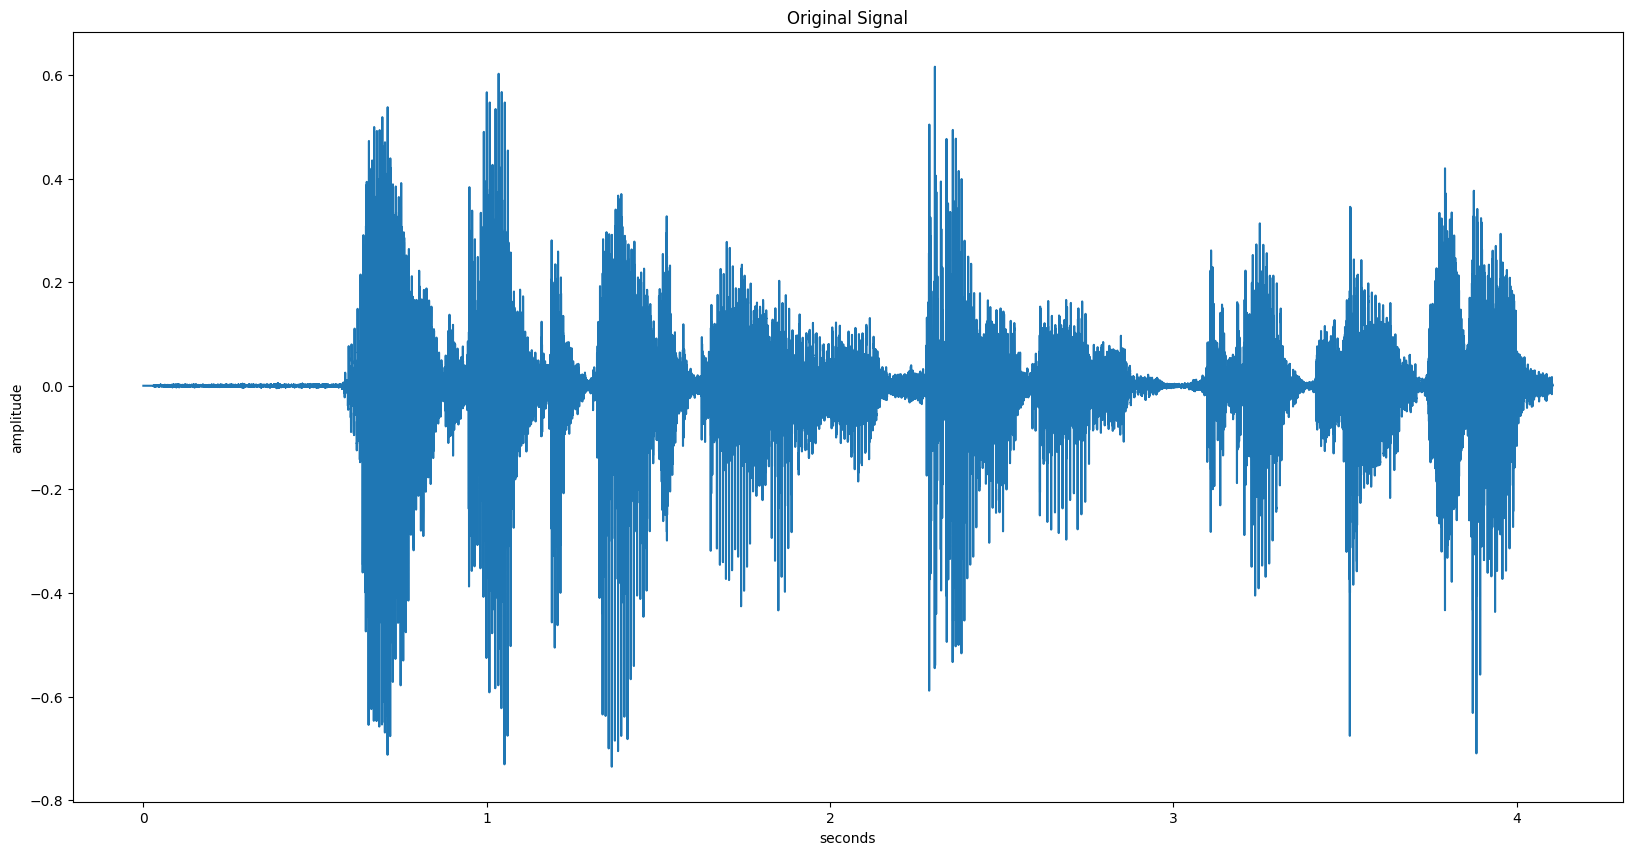

In [19]:
audio_file = AudioSegment.from_mp3(path)
length_in_seconds = len(audio_file) / 1000  # Convert from milliseconds to seconds
audio , sr = librosa.load(path, sr=None)
number_samples = audio.shape[0]
delta = length_in_seconds/number_samples
time = np.linspace(0,(number_samples-1) * delta,number_samples)

plt.figure(figsize=(20,10))
plt.title('Original Signal')
plt.plot(time,audio)
plt.ylabel('amplitude')
plt.xlabel('seconds')
plt.show()

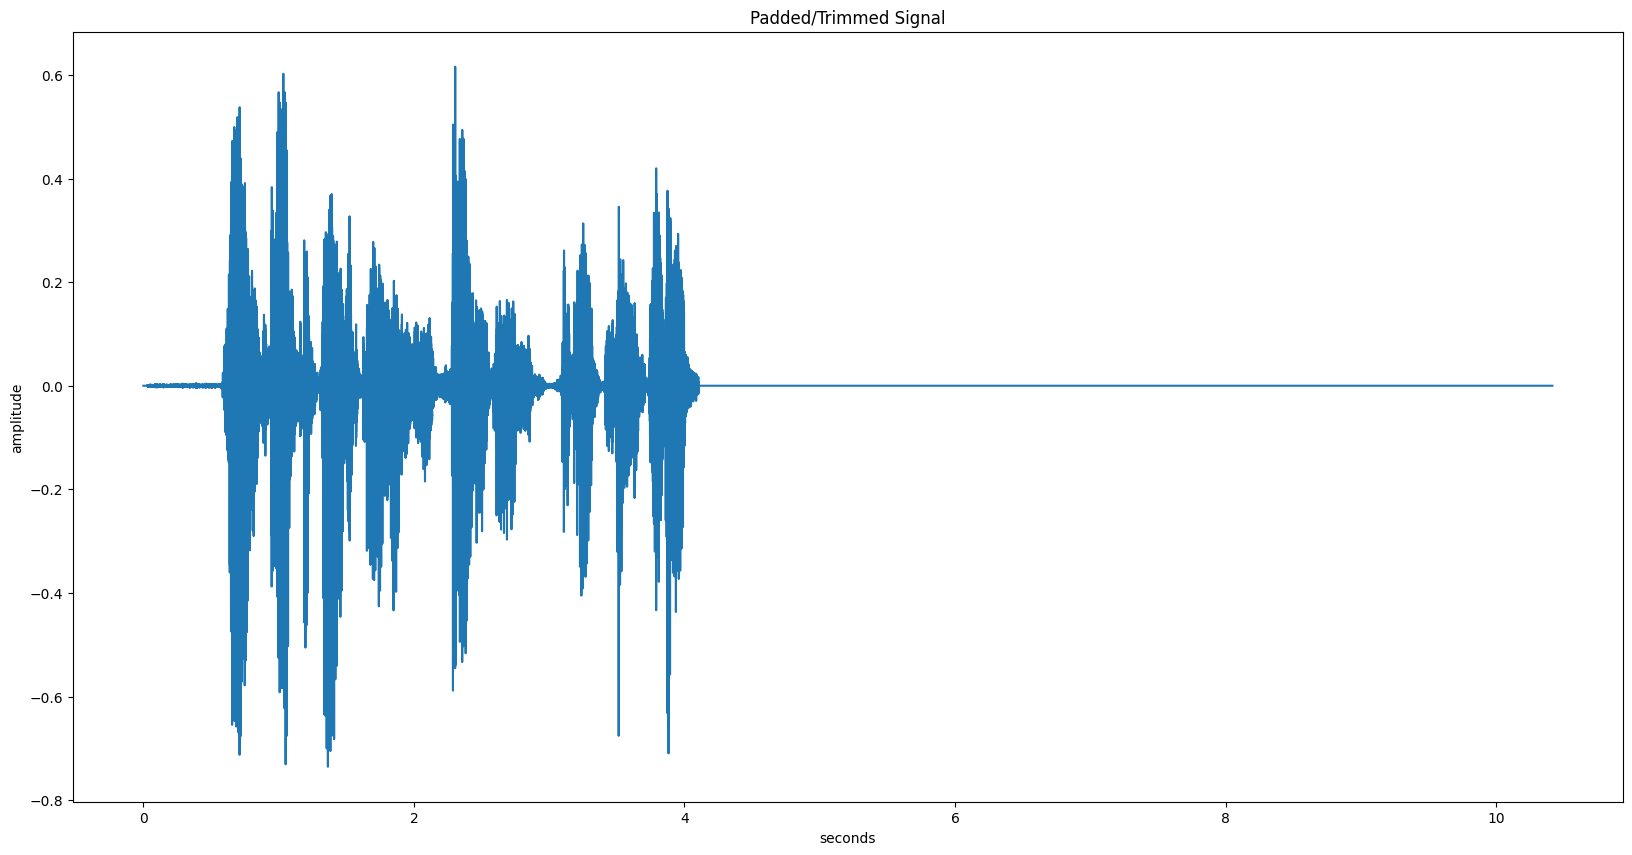

In [8]:
padded_audio = pad_or_trim(audio, 500000)

length_in_seconds = length_in_seconds * padded_audio.shape[0] / audio.shape[0] 
number_samples = padded_audio.shape[0]
delta = length_in_seconds/number_samples
time = np.linspace(0,(number_samples-1) * delta,number_samples)

plt.figure(figsize=(20,10))
plt.title('Padded/Trimmed Signal')
plt.plot(time,padded_audio)
plt.ylabel('amplitude')
plt.xlabel('seconds')
plt.show()

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


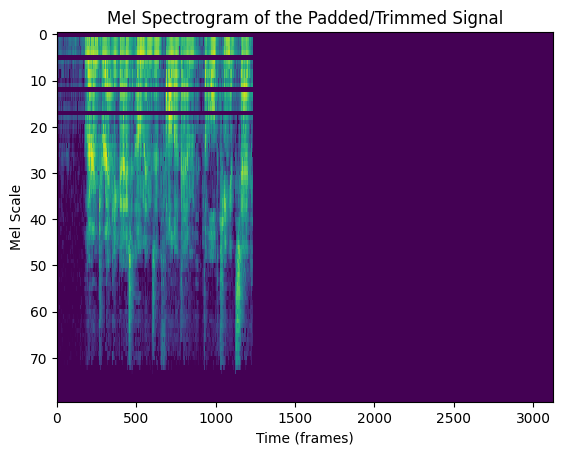

In [9]:
mel_spectrogram = log_mel_spectrogram(padded_audio, sr)

plt.imshow(mel_spectrogram, interpolation='nearest', aspect='auto')
plt.title('Mel Spectrogram of the Padded/Trimmed Signal')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Scale')

plt.show()

In [10]:
df.shape

(10000, 2)

**Processing the text**

In [11]:
df['text'] = df['text'].str.lower()

In [12]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    return text

df['text'] = df['text'].apply(clean_text)

In [13]:
df['text'] = df['text'].apply(fix)

In [14]:
df['text_tokens'] = df['text'].apply(lambda x: x.split())

In [15]:
df['char_tokens'] = df['text'].apply(lambda x: list(x))

In [16]:
# Define character set
char_set = list(string.ascii_lowercase) + [" "]  # Add space
char_to_index = {char: idx+1 for idx, char in enumerate(char_set)}  # Indexing starts from 1
char_to_index["<PAD>"] = 0  # Padding token

# Function to convert text to indices
def text_to_indices(text):
    return [char_to_index[char] for char in text if char in char_to_index]

df['text_indices'] = df['text'].apply(text_to_indices)

In [17]:
max_length = max(df['text_indices'].apply(len))  # Find longest sequence

df['padded_text_indices'] = list(pad_sequences(df['text_indices'], maxlen=max_length, padding='post', value=0))

In [18]:
df.head()

,speech,text,text_tokens,char_tokens,text_indices,padded_text_indices
0,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",learn to recognize omens and follow them the o...,"[learn, to, recognize, omens, and, follow, the...","[l, e, a, r, n, , t, o, , r, e, c, o, g, n, ...","[12, 5, 1, 18, 14, 27, 20, 15, 27, 18, 5, 3, 1...","[12, 5, 1, 18, 14, 27, 20, 15, 27, 18, 5, 3, 1..."
1,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",everything in the universe evolved he said,"[everything, in, the, universe, evolved, he, s...","[e, v, e, r, y, t, h, i, n, g, , i, n, , t, ...","[5, 22, 5, 18, 25, 20, 8, 9, 14, 7, 27, 9, 14,...","[5, 22, 5, 18, 25, 20, 8, 9, 14, 7, 27, 9, 14,..."
2,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",you came so that you could learn about your dr...,"[you, came, so, that, you, could, learn, about...","[y, o, u, , c, a, m, e, , s, o, , t, h, a, ...","[25, 15, 21, 27, 3, 1, 13, 5, 27, 19, 15, 27, ...","[25, 15, 21, 27, 3, 1, 13, 5, 27, 19, 15, 27, ..."
3,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",so now i fear nothing because it was those ome...,"[so, now, i, fear, nothing, because, it, was, ...","[s, o, , n, o, w, , i, , f, e, a, r, , n, ...","[19, 15, 27, 14, 15, 23, 27, 9, 27, 6, 5, 1, 1...","[19, 15, 27, 14, 15, 23, 27, 9, 27, 6, 5, 1, 1..."
4,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",if you start your emails with greetings let me...,"[if, you, start, your, emails, with, greetings...","[i, f, , y, o, u, , s, t, a, r, t, , y, o, ...","[9, 6, 27, 25, 15, 21, 27, 19, 20, 1, 18, 20, ...","[9, 6, 27, 25, 15, 21, 27, 19, 20, 1, 18, 20, ..."
